# Spatial display for Wetlands Insight Tool results <img align="right" src="../Supplementary_data/dea_logo.jpg">

* **Compatibility:** Notebook currently compatible with only the `NCI VDI` environment


* **Special requirements:** 
    * If running on the [NCI](https://nci.org.au/), ensure that `module load dea` is   run prior to launching this notebook
    * Check you have the latest version of the `wit_tooling package` by 
      copying and pasting the following code into a cell below and running the cell
    `!pip install --user git+git://github.com/GeoscienceAustralia/wit_tooling`
      
      
* **Products used:** 
    * Collection 2 Landsat Surface Reflectance: 
    [ls5_nbart_albers](https://explorer.dea.ga.gov.au/ls5_nbart_albers),
    [ls7_nbart_albers](https://explorer.dea.ga.gov.au/ls7_nbart_albers),
    [ls8_nbart_albers](https://explorer.dea.ga.gov.au/ls8_nbart_albers)
    * Collection 2 Landsat Fractional Cover, 
    generated using the Joint Remote Sensing Research Program algorithm: 
    [ls5_fc_albers](https://explorer.dea.ga.gov.au/ls5_fc_albers),
    [ls7_fc_albers](https://explorer.dea.ga.gov.au/ls7_fc_albers),
    [ls8_fc_albers](https://explorer.dea.ga.gov.au/ls8_fc_albers)
    * Water Observations from Space, 
    generated using the Geoscience Australia Algorithm:
    [wofs_albers](https://explorer.sandbox.dea.ga.gov.au/wofs_albers)



## Background
The Spatial Wetlands Insight Tool is a tool in development to display the coverage of water, "wetness" and vegetation fractional cover in a wetland spatially. It is generated off existing Wetlands Insight Tool temporal runs. 

## Description
This notebook uses an existing Wetlands Insight Tool temporal plot, 
generated from an existing WIT run, to create a spatial plot of water, "wetness", green/photosynthetic vegetation, dry/non-photosynthetic vegetation, and bare soil for a chosen observation date. 

1. First we load the existing WIT data from either: 
    * a saved csv location
    * a shapefile to retrieve the existing WIT data from the database of previous runs
    * a csv from an Amazon s3 data bucket
2. Then we choose a time of interest to plot Spatial WIT
3. Finally we output Spatial WIT to a file for each cover type
***

Before running this notebook:
-----------------------------
* Follow the instructions under `Special Requirements` above to load `dea` and install `wit_tooling`

## Load packages

In [72]:
# import all the necessary packages in this cell
import pandas as pd
import numpy as np
import fiona
import geopandas as gpd
import xarray as xr

import matplotlib.pyplot as plt
from matplotlib.gridspec import GridSpec
import matplotlib.dates as mdates
from matplotlib.patches import Rectangle

from datacube.utils.cog import write_cog

import datetime

from os import path
import os, sys, logging
import seaborn as sns
import ssl

from wit_tooling import load_wit_data, query_datasets, construct_product, load_wofs_fc, generate_raster, spatial_wit

In [2]:
# output_notebook()
# ssl._create_default_https_context = ssl._create_unverified_context

In [12]:
_LOG = logging.getLogger(__name__)
stdout_hdlr = logging.StreamHandler(sys.stdout)
formatter = logging.Formatter('[%(asctime)s.%(msecs)03d - %(levelname)s] %(message)s')
stdout_hdlr.setFormatter(formatter)
_LOG.addHandler(stdout_hdlr)
_LOG.setLevel(logging.DEBUG)

### Global variables
If you are using a shapefile, csv file, or Amazon s3 link to the existing WIT run, 
the path must be set in the cell below this cell:

* `shapefile`: NCI path to shapefile 
(e.g. `'/g/data1a/r78/DEA_Wetlands/shapefiles/ramsar_wetlands_3577_20190403.shp'`). 
You must have permissions to the project directory,
and the shapefile must be in [Australian Albers EPSG 3577 projection](https://spatialreference.org/ref/epsg/gda94-australian-albers/)
* `csv_file`: NCI path to WIT results CSV (e.g. `'/g/data1a/u46/users/ea6141/dea-notebooks/Spatial_WIT/sample_data/Western Port_Western Port_VIC_19.csv'`)
* `pd_yaml`: Yaml file necessary to generate WIT 
e.g. `'/g/data/u46/users/ea6141/wit_tooling/aux/fc_pd.yaml'`). 
Specifies input datasets.
* `s3_url`: Amazon s3 url link to pre-generated WIT csvs folder 
(e.g. `'https://dea-public-data-dev.s3-ap-southeast-2.amazonaws.com/Wetlands_Insight_Tool/WIT_v3'`). 


In [3]:
# put global variables in this cell
shapefile = '/g/data/r78/DEA_Wetlands/shapefiles/ramsar_wetlands_3577_20190403.shp'
#csv_file = '/g/data1a/u46/users/ea6141/dea-notebooks/Spatial_WIT/sample_data/Western Port_Western Port_VIC_19.csv'
pd_yaml = '/g/data/u46/users/ea6141/wit_tooling/aux/fc_pd.yaml'
s3_url = 'https://dea-public-data-dev.s3-ap-southeast-2.amazonaws.com/Wetlands_Insight_Tool/WIT_v3/Kerang%20Wetlands_Hird%20Swamp_VIC_17.csv'

In [4]:
def save_geotiff(spatial_wit_xr, filename, force=False):
    """
        save spatial WIT result to geotiffs, each band will be output to individual tiff
        input:
            an xarray Dataset of spatial WIT
            overwrite existing file if force=True, otherwise no output
        output:
            multiple cloud-optimized geotiffs (cogs) on disk
    """
    for var in spatial_wit_xr.data_vars:       
        #create file name per band
        band_output = file_name + "_" + var + ".tif"
        if path.exists(band_output):
            _LOG.warning("output geotif %s exists", band_output)
            if force:
                _LOG.warning("existing geotif %s will be overwritten", band_output)
                os.remove(band_output)
            else:
                continue
        spatial_wit_xr[var].attrs.update(spatial_wit_xr.attrs)
        write_cog(spatial_wit_xr[var], band_output, blocksize=16)
    return

## Load WIT data using one of the methods in the cell below

In [5]:
# A list we wanna explore
#poly_candidates = {1: 1, 5: 5, 116: 116, 103: 103, 2: 2, 112: 112}
poly_candidates = {42:42}

In [6]:
# todo: iterate over all possible loading routes,
# i.e., database and csv on s3 (not responsible for local csv, users supposed to know)
# load wit data from database with a chosen shape
with fiona.open(shapefile) as allshapes:
    shape_crs = allshapes.crs_wkt
    shape_list = iter(allshapes)
    while True:
        shape = next(shape_list)
        if int(shape['id']) == poly_candidates[42]:
            break
    #polyName = shape['properties'].get('WetlandNam', '')
    poly_outline = np.array(shape['geometry']['coordinates'][0])
   # s3_filename = 'area_percent_' + shape['id'] + '_0.csv'
    wit_data = load_wit_data(s3_url='https://dea-public-data-dev.s3-ap-southeast-2.amazonaws.com/Wetlands_Insight_Tool/WIT_v3/Kerang%20Wetlands_Hird%20Swamp_VIC_17.csv')

### Check the shapefile to make sure we've got the correct polygon

In [7]:
shape_df = gpd.read_file(shapefile)

In [8]:
shape_df[42:43]

,REFCODE,RAMSAR_NAM,WETLAND_NA,STATE,JURISDICTI,DESIGNATIO,TOTAL_SITE,GAZETTED_A,SOURCE,METADATA_U,WETLANDSDB,AREA_HA,geometry
42,17,Kerang Wetlands,Hird Swamp,VIC,VIC,1982-12-15,0.0,9419.0,Department of Environment and Primary Industri...,http://services.land.vic.gov.au/SpatialDatamar...,http://www.environment.gov.au/cgi-bin/wetlands...,433.68127,"POLYGON ((1090599.724 -3968110.105, 1090900.93..."


Hird Swamp


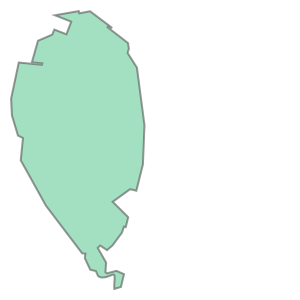

In [9]:
#Check that #42 is Hird Swamp
print(shape_df['WETLAND_NA'][42])
polyName = shape_df['WETLAND_NA'][42]
shape_df['geometry'][42]

### Spatial wit for the chosen shape

In [10]:
# it's helpful to get the location of data rather than load them
# and it will save you time without querying database multiple times
time_range = (wit_data.utc_time.min(), wit_data.utc_time.max())

In [13]:
#build a product for our data using the yaml file to specify which datasets we need
fc_product = construct_product(pd_yaml)
datasets = query_datasets(fc_product, shape, shape_crs, time_range)
_LOG.debug("Query datasets %s", datasets)

[2021-05-24 11:16:32,194.194 - DEBUG] Query datasets <VirtualDatasetBox of shape {'time': 1091, 'y': 152, 'x': 74}>


Retrieve spatial wit for the dates we have chosen to show in the WIT paper

In [14]:
#setup dates for the paper figure 
paper_dates = [datetime.date(1987,9,30),
              datetime.date(1998,4,30),
              datetime.date(1999,4,1),
              datetime.date(2009,4,4),
              datetime.date(2011,1,28),
              datetime.date(2017,9,26),
              datetime.date(2019,6,28)]

#convert the times (from the paper figure) into timestamps by finding the closest times, and hoping they match
paper_ixs = [abs(wit_data.utc_time-t).argmin() for t in pd.to_datetime(paper_dates)]

# take time slice to init spatial wit plot
time_slice = np.datetime64(wit_data.utc_time[paper_ixs[0]])
_LOG.debug("load time slice %s", time_slice)

#load the first data array for spatial wit
fc_wofs_data = load_wofs_fc(fc_product, datasets, time_slice)

#load our time slices in a loop
time_slices = [np.datetime64(wit_data.utc_time[paper_ixs[0]])]

for i in range(0,6):
    # set the time slice, load the time slice, then concatenate the arrays. 
    time_slice = np.datetime64(wit_data.utc_time[paper_ixs[i+1]])
    time_slices.append(time_slice)
    _LOG.debug("load time slice %s", time_slice)
    fc_wofs_data_new = load_wofs_fc(fc_product, datasets, time_slice)
    #add the new one to the existing one and hope it works
    fc_wofs_data = xr.concat([fc_wofs_data, fc_wofs_data_new],'time')

mask spatial wit by the geometry of given polygon

In [16]:
# first parameter of generate_raster is a tuple of (shape geometry, [integer of shape id])
mask = generate_raster([(shape['geometry'], int(shape['id']))], datasets.geobox)
fc_wofs_perc = spatial_wit(fc_wofs_data, mask)

/g/data/v10/public/modules/dea/20201217/lib/python3.6/site-packages/datacube/utils/geometry/_base.py:301: DeprecationWarning: Please use `str(crs)` instead of `crs.crs_str`
  warnings.warn("Please use `str(crs)` instead of `crs.crs_str`", category=DeprecationWarning)


get our temporal wit data into a form that we can plot nicely

In [17]:
if wit_data.water.max() <= 1.0:
    #multiply our pandas bare, wet, green, dry, water by 100 to make plotting perc
    wit_data.iloc[:,1:] = wit_data[wit_data.columns[1:]].apply(lambda x: x * 100)

In [19]:
wit_data.head()

,utc_time,bare,dry,green,wet,water
no,,,,,,
0,1987-09-23 23:36:17.000,8.656640,44.340726,39.799279,3.271417,2.786249
1,1987-09-30 23:42:36.500,8.269060,42.475603,41.336291,2.855559,3.909066
2,1987-10-09 23:36:36.500,9.259773,41.064042,42.291932,3.229831,2.952592
3,1987-10-25 23:36:51.500,6.811062,41.103965,45.614500,3.493208,1.774328
4,1987-11-17 23:43:32.500,6.834766,48.086776,40.529803,2.633768,0.665373


In [20]:
fc_wofs_data

<xarray.Dataset>
Dimensions:      (time: 7, x: 74, y: 152)
Coordinates:
    spatial_ref  int32 3577
  * x            (x) float64 1.09e+06 1.09e+06 1.09e+06 ... 1.091e+06 1.091e+06
  * y            (y) float64 -3.968e+06 -3.968e+06 ... -3.972e+06 -3.972e+06
  * time         (time) datetime64[ns] 1987-09-30T23:42:36.500000 ... 2019-06...
Data variables:
    BS           (time, y, x) int8 3 0 0 0 6 11 13 16 ... 15 17 13 29 17 15 15
    PV           (time, y, x) int8 82 83 82 79 75 66 58 ... 49 50 52 44 40 54 58
    NPV          (time, y, x) int8 13 15 16 19 18 22 28 ... 34 32 34 26 42 30 25
    TCW          (time, y, x) float32 -841.1283 -845.9027 ... -1264.08
    water        (time, y, x) bool False False False False ... False False False
Attributes:
    crs:           EPSG:3577
    grid_mapping:  spatial_ref

ok our two datasets, wit_data for the WIT plot and fc_wofs_data for our spatial WIT plots are ready. 

Create a wit temporal plot with wit spatial wit plots above it

In [ ]:
# '''code to create the WIT temporal and spatial plots '''
# #tell bokeh the data comes from a pandas dataframe
# source = ColumnDataSource(data=wit_data)

# #bex genuinely has no idea what this does
# for i in range(10):
#     source.data['dummy'+str(i)] = np.ones(source.data['utc_time'].shape) * i * 10

In [21]:
#set up color palate for bokeh WIT plot
pal = [sns.xkcd_rgb["cobalt blue"],
       sns.xkcd_rgb["neon blue"],
       sns.xkcd_rgb["grass"],
       sns.xkcd_rgb["beige"],
       sns.xkcd_rgb["brown"]]  

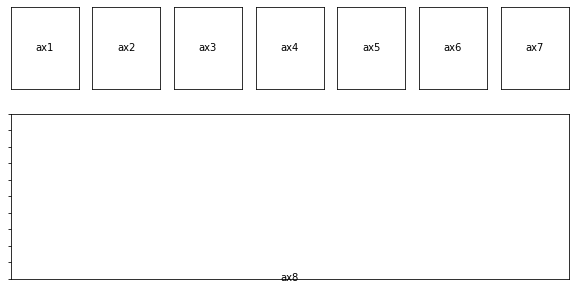

In [76]:
 #....aaaand ---- trying with matplotlib gridplots instead
    
def make_ticklabels_invisible(fig):
    for i, ax in enumerate(fig.axes):
        #ax.text(0.5, 0.5, "ax%d" % (i+1), va="center", ha="center")
        ax.text(0.5, 0.5, "ax%d" % (i+1), va="center", ha="center")
        for tl in ax.get_xticklabels() + ax.get_yticklabels():
            tl.set_visible(False)
        #turn off the ticks for everything except the last one
        if i <=6:    
            ax.tick_params(bottom=False, labelbottom=False, left=False, labelleft=False)   
        #for the WIT plot, set up the axes
        if i == 7: 
            #set date ticks every year
            years = mdates.YearLocator(2)
            yearsFmt = mdates.DateFormatter('%Y')
            ax.xaxis.set_major_locator(years)
            ax.xaxis.set_major_formatter(yearsFmt)
            ax.yaxis.set_ticks(np.arange(0,110,10))
            
            
#set the figure size and parameters            
f = plt.figure(figsize=(10,5))

gs = GridSpec(2, 7,
                       #width_ratios=[1,8],
                      height_ratios=[1,2]
                       )

# setup the gridspec for subplots
ax1 = f.add_subplot(gs[0,0])
ax2 = f.add_subplot(gs[0,1])
ax3 = f.add_subplot(gs[0,2])
ax4 = f.add_subplot(gs[0,3])
ax5 = f.add_subplot(gs[0,4])
ax6 = f.add_subplot(gs[0,5])
ax7 = f.add_subplot(gs[0,6])
ax8 = f.add_subplot(gs[1,:])

#make our plots




#then our witplot at the end
ax8.varea_stack(['water', 
              'wet',
              'green',
              'dry',
              'bare'], x= 'utc_time', name = "stackplot", color=pal, fill_alpha=0.7, source = source, 
              legend_label=["water","wet","green","dry","bare"], muted_color="grey", muted_alpha=0.2)





make_ticklabels_invisible(f)
plt.show()    
    

In [ ]:


# #align the title in the centre
# wit_plot.title.align= "center"
# wit_plot.title.text_font_size="12pt"

#label axes
wit_plot.yaxis.axis_label=("%")

#set our desired axes number displays
wit_plot.xaxis.formatter=DatetimeTickFormatter()
wit_plot.xaxis.ticker = YearsTicker(interval=2, desired_num_ticks=30)
wit_plot.xaxis.major_tick_in =0
wit_plot.xaxis.major_label_orientation = 45
wit_plot.yaxis.ticker = AdaptiveTicker(desired_num_ticks=10)

#set the new WIT graph ranges
left, right, bottom, top = source.data['utc_time'][0], source.data['utc_time'][-1], 0, 100 #set 
wit_plot.x_range=Range1d(left, right)
wit_plot.y_range=Range1d(bottom, top)
wit_plot.xaxis.bounds=(left,right)
wit_plot.yaxis.bounds=(bottom,top)

#now we want to overplot the data on the plot
#create rectangle borders for no-data times (SLC-off only)
LS5_8_gap_start = datetime.datetime(2011,11,1)
LS5_8_gap_end = datetime.datetime(2013,4,1)

#plot our dead satellite rectangle
wit_plot.hbar(y=50, 
       height=100,
       left=LS5_8_gap_start, 
       right=LS5_8_gap_end, 
       name ="LS7 SLC-OFF",
       color="white", 
       alpha=0.5, 
       hatch_color="white", 
       hatch_pattern='/',
       hatch_alpha=0.6,
       line_color="white",
       line_width =2,
       line_alpha=0.6)

wit_plot.legend.location="bottom_left"
wit_plot.legend.background_fill_alpha=0.5
wit_plot.legend.border_line_alpha=0.5
wit_plot.legend.label_text_font_size="9pt" 

#reverse the legend 
wit_plot.legend[0].items.reverse()

In [ ]:
#lets put a title on the plot
#title =f'Wetlands Insight Tool plot for a temporary palustrine marsh'    

#set up the x axis to recognise date and time. Note that you will only see the days when you zoom in.
wit_plot = figure(#plot_width=1400, 
          #plot_height = 400, 
          x_axis_type='datetime',
         #title=title)#, 
    tools="save")
    #["box_select", ResetTool(), BoxZoomTool(dimensions="width")])
hovernames = []
nonselected_circle = Circle(fill_alpha=0, fill_color=None, line_color=None)
for i in range(10):
    circle_group_name = 'circlegroup' + str(i)
    renderer = wit_plot.circle(y="dummy" + str(i), x= 'utc_time', size=20, fill_color=None, 
                    line_alpha=0, source = source, muted_color="white", muted_alpha=0, name=circle_group_name)
    renderer.nonselection_glyph = nonselected_circle
    hovernames.append(circle_group_name)
wit_plot.varea_stack(['water', 
              'wet',
              'green',
              'dry',
              'bare'], x= 'utc_time', name = "stackplot", color=pal, fill_alpha=0.7, source = source, 
              legend_label=["water","wet","green","dry","bare"], muted_color="grey", muted_alpha=0.2)
#wit_plot.sizing_mode = "scale_width"

#align the title in the centre
wit_plot.title.align= "center"
wit_plot.title.text_font_size="12pt"

#label axes
wit_plot.yaxis.axis_label=("%")
#wit_plot.yaxis.axis_label_text_font_size="12pt"

#wit_plot.xaxis.axis_label="Observation date"
#wit_plot.yaxis.axis_label_text_font_size="12pt"

#we need screen units to put the attribution label under the plot. Don't ask why.
label_opts = dict(
    x=0, 
    y=0,
    x_units='screen', 
    y_units='screen',
    text_font_style="italic", 
    text_font_size="8.5pt")

#set our desired axes number displays
wit_plot.xaxis.formatter=DatetimeTickFormatter()
wit_plot.xaxis.ticker = YearsTicker(interval=2, desired_num_ticks=30)
wit_plot.xaxis.major_tick_in =0
wit_plot.xaxis.major_label_orientation = 45
wit_plot.yaxis.ticker = AdaptiveTicker(desired_num_ticks=10)

#set the new WIT graph ranges
left, right, bottom, top = source.data['utc_time'][0], source.data['utc_time'][-1], 0, 100 #set 
wit_plot.x_range=Range1d(left, right)
wit_plot.y_range=Range1d(bottom, top)
wit_plot.xaxis.bounds=(left,right)
wit_plot.yaxis.bounds=(bottom,top)

#now we want to overplot the data on the plot
#create rectangle borders for no-data times (SLC-off only)
LS5_8_gap_start = datetime.datetime(2011,11,1)
LS5_8_gap_end = datetime.datetime(2013,4,1)

#plot our dead satellite rectangle
wit_plot.hbar(y=50, 
       height=100,
       left=LS5_8_gap_start, 
       right=LS5_8_gap_end, 
       name ="LS7 SLC-OFF",
       color="white", 
       alpha=0.5, 
       hatch_color="white", 
       hatch_pattern='/',
       hatch_alpha=0.6,
       line_color="white",
       line_width =2,
       line_alpha=0.6)

wit_plot.legend.location="bottom_left"
wit_plot.legend.background_fill_alpha=0.5
wit_plot.legend.border_line_alpha=0.5
wit_plot.legend.label_text_font_size="9pt" 

#reverse the legend 
wit_plot.legend[0].items.reverse()

#spatial wit plot

image_list = {}
color_map_dict = {}

#this is probably a very hacky way of setting up new lists
image_list1 = {}

# all below is to setup the pallete
transparent_white = RGB(255, 255, 255, 0)
colbat_blue = [RGB(3, 10, 167, 1)]
neon_blue = [RGB(4, 217, 255, 1)]
grass_green = [RGB(63, 155, 11, t) for t in np.arange(0.1, 1, 0.1)]
soil_brown = [RGB(96, 70, 15, t) for t in np.arange(0.1, 1, 0.1)]
dry_biege = [RGB(230, 218, 166, t) for t in np.arange(0.1, 1, 0.1) ]
var_colors = [soil_brown, grass_green, dry_biege, neon_blue, colbat_blue]


#this is set up to work for time index 0
for var, cm in zip(fc_wofs_perc.data_vars, var_colors):
    image_list[var] = [np.flip(fc_wofs_perc[var].data[0], axis=0)]
    color_map_dict[var] = LinearColorMapper([transparent_white]+cm, low=0, high=100,
                               nan_color=transparent_white)
sw_source = ColumnDataSource(data=image_list)

# set up the spatial wit plots
sw_plot0 = figure(plot_width=200, plot_height = 300)
#again, hacked to work for time index 0
for var in fc_wofs_perc.isel(time=0).data_vars:
    sw_plot0.image(image=var, source=sw_source, x=fc_wofs_data.x.data.min(), y=fc_wofs_data.y.data.min(),
        dh=(fc_wofs_data.y.data.max() - fc_wofs_data.y.data.min()),
        dw=(fc_wofs_data.x.data.max() - fc_wofs_data.x.data.min()),
        color_mapper = color_map_dict[var])
sw_plot0.line(poly_outline[:,0], poly_outline[:,1], line_width=3)
sw_plot0.y_range.update(start=poly_outline[:,1].min(), end=poly_outline[:,1].max())
sw_plot0.x_range.update(start=poly_outline[:,0].min(), end=poly_outline[:,0].max())

sw_plot0.title.text = "%s" % time_slices[0].astype('datetime64[D]')
sw_plot0.title.text_font_size="12pt"
sw_plot0.axis.visible = None
sw_plot0.min_border_left = 0

In [ ]:
#spatial wit plot rebuild -bokeh - for munging
time_ix = 1
for var, cm in zip(fc_wofs_perc.data_vars, var_colors):
    image_list1[var] = [np.flip(fc_wofs_perc[var].data[time_ix], axis=0)]
    color_map_dict[var] = LinearColorMapper([transparent_white]+cm, low=0, high=100,
                               nan_color=transparent_white)
sw1_source = ColumnDataSource(data=image_list1)

sw_plot1 = figure(plot_width=200, plot_height = 300)
for var in fc_wofs_perc.isel(time = time_ix).data_vars:
    
    sw_plot1.image(image=var, source=sw1_source, x=fc_wofs_data.x.data.min(), y=fc_wofs_data.y.data.min(),
        dh=(fc_wofs_data.y.data.max() - fc_wofs_data.y.data.min()),
        dw=(fc_wofs_data.x.data.max() - fc_wofs_data.x.data.min()),
        color_mapper = color_map_dict[var])
sw_plot1.line(poly_outline[:,0], poly_outline[:,1], line_width=3)
sw_plot1.y_range.update(start=poly_outline[:,1].min(), end=poly_outline[:,1].max())
sw_plot1.x_range.update(start=poly_outline[:,0].min(), end=poly_outline[:,0].max())

sw_plot1.title.text = "%s" % time_slices[time_ix].astype('datetime64[D]')
sw_plot1.title.text_font_size="12pt"
sw_plot1.axis.visible = None
sw_plot1.min_border_left = 0

#---this is not a good way to do this...

time_ix = 2
for var, cm in zip(fc_wofs_perc.data_vars, var_colors):
    image_list1[var] = [np.flip(fc_wofs_perc[var].data[time_ix], axis=0)]
    color_map_dict[var] = LinearColorMapper([transparent_white]+cm, low=0, high=100,
                               nan_color=transparent_white)
sw2_source = ColumnDataSource(data=image_list1)

sw_plot2 = figure(plot_width=200, plot_height = 300)
for var in fc_wofs_perc.isel(time = time_ix).data_vars:
    
    sw_plot2.image(image=var, source=sw2_source, x=fc_wofs_data.x.data.min(), y=fc_wofs_data.y.data.min(),
        dh=(fc_wofs_data.y.data.max() - fc_wofs_data.y.data.min()),
        dw=(fc_wofs_data.x.data.max() - fc_wofs_data.x.data.min()),
        color_mapper = color_map_dict[var])
sw_plot2.line(poly_outline[:,0], poly_outline[:,1], line_width=3)
sw_plot2.y_range.update(start=poly_outline[:,1].min(), end=poly_outline[:,1].max())
sw_plot2.x_range.update(start=poly_outline[:,0].min(), end=poly_outline[:,0].max())

sw_plot2.title.text = "%s" % time_slices[time_ix].astype('datetime64[D]')
sw_plot2.title.text_font_size="12pt"
sw_plot2.axis.visible = None
sw_plot2.min_border_left = 0

In [ ]:
##--unedited bokeh version--##

# def plot_doc(doc):
#     '''code to create the WIT temporal and spatial plots '''
#     #tell bokeh the data comes from a pandas dataframe
#     source = ColumnDataSource(data=wit_data)
    
#     for i in range(10):
#         source.data['dummy'+str(i)] = np.ones(source.data['utc_time'].shape) * i * 10

#     #set up color palate for bokeh WIT plot
#     pal = [sns.xkcd_rgb["cobalt blue"],
#            sns.xkcd_rgb["neon blue"],
#            sns.xkcd_rgb["grass"],
#            sns.xkcd_rgb["beige"],
#            sns.xkcd_rgb["brown"]]  

#     #lets put a title on the plot
#     title =f'Percentage of area dominated by WOfS, Wetness, Fractional Cover for {polyName}'    

#     #set up the x axis to recognise date and time. Note that you will only see the days when you zoom in.
#     wit_plot = figure(plot_width=1200, 
#               plot_height = 400, 
#               x_axis_type='datetime',
#              title=title, tools=["box_select", ResetTool(), BoxZoomTool(dimensions="width")])
    
#     hovernames = []
#     nonselected_circle = Circle(fill_alpha=0, fill_color=None, line_color=None)
#     for i in range(10):
#         circle_group_name = 'circlegroup' + str(i)
#         renderer = wit_plot.circle(y="dummy" + str(i), x= 'utc_time', size=20, fill_color=None, 
#                         line_alpha=0, source = source, muted_color="white", muted_alpha=0, name=circle_group_name)
#         renderer.nonselection_glyph = nonselected_circle
#         hovernames.append(circle_group_name)
#     wit_plot.varea_stack(['water', 
#                   'wet',
#                   'green',
#                   'dry',
#                   'bare'], x= 'utc_time', name = "stackplot", color=pal, fill_alpha=0.7, source = source, 
#                   legend_label=["water","wet","green","dry","bare"], muted_color="grey", muted_alpha=0.2)
#     wit_plot.sizing_mode = "scale_width"

#     #align the title in the centre
#     wit_plot.title.align= "center"
#     wit_plot.title.text_font_size="12pt"

#     #label axes
#     wit_plot.yaxis.axis_label=("percentage of polygon classified as type")
#     wit_plot.yaxis.axis_label_text_font_size="8pt"

#     #we need screen units to put the attribution label under the plot. Don't ask why.
#     label_opts = dict(
#         x=0, 
#         y=0,
#         x_units='screen', 
#         y_units='screen',
#         text_font_style="italic", 
#         text_font_size="8.5pt")

#     #underplot context
#    # msg1 = 'The Fractional Cover algorithm developed by the Joint Remote Sensing Research Program\n\
#    # and the Water Observations from Space algorithm developed by Geoscience Australia are used in the production of this data'
#    # caption1 = Label(text=msg1, **label_opts)

#     wit_plot.add_layout(caption1, 'below')

#     wit_plot.xaxis.formatter=DatetimeTickFormatter()
#     wit_plot.xaxis.ticker = YearsTicker(interval=1)
#     wit_plot.xaxis.major_label_orientation = 45
    
#     #set the new WIT graph ranges.
#     left, right, bottom, top = source.data['utc_time'][0], source.data['utc_time'][-1], 0, 100 #set 
#     wit_plot.x_range=Range1d(left, right)
#     wit_plot.y_range=Range1d(bottom, top)
#     wit_plot.xaxis.bounds=(left,right)
#     wit_plot.yaxis.bounds=(bottom,top)

#     #now we want to overplot the data on the plot
#     #create rectangle borders for no-data times (SLC-off only)
#     LS5_8_gap_start = datetime.datetime(2011,11,1)
#     LS5_8_gap_end = datetime.datetime(2013,4,1)

#     #plot our dead satellite rectangle
#     wit_plot.hbar(y=50, 
#            height=100,
#            left=LS5_8_gap_start, 
#            right=LS5_8_gap_end, 
#            name ="LS7 SLC-OFF",
#            color="white", 
#            alpha=0.5, 
#            hatch_color="white", 
#            hatch_pattern='/',
#            hatch_alpha=0.6,
#            line_color="white",
#            line_width =2,
#            line_alpha=0.6)

#     wit_plot.legend.location="bottom_left"
#     wit_plot.legend.background_fill_alpha=0.5
#     wit_plot.legend.border_line_alpha=0.5
#     wit_plot.legend.label_text_font_size="9pt" 

#     #reverse the legend 
#     wit_plot.legend[0].items.reverse()
    
#     wit_hover = HoverTool(names = hovernames,
#                       tooltips = [
#         ("observation", "$index"),
#         ("date", "@utc_time{%F}"),
#         ("bare","@bare{0.0}%"),
#         ("dry", "@dry{0.0}%"),
#         ("green","@green{0.0}%"),
#         ("wet","@wet{0.0}%"),
#         ("water","@water{0.0}%")],     
#                     formatters=
#         {"@utc_time":"datetime"})

#     #trialling different ways of getting the tools to work. Both adding tools and including in the figure work.
#     wit_plot.add_tools(wit_hover, WheelZoomTool(), SaveTool())
    
#     # down below is interactivity between plots
#     # WARNING: DON'T MODIFY UNLESS YOU ABSOLUTELY KNOW WHAT YOU'RE DOING
#     def sw_update(attrname, old, new):
#         time_slice = new
#         fc_wofs_data = load_wofs_fc(fc_product, datasets, np.datetime64(time_slice))
#         fc_wofs_perc = spatial_wit(fc_wofs_data, mask)
#         for var in fc_wofs_perc.data_vars:
#             sw_source.data[var] = [np.flip(fc_wofs_perc[var].data[0], axis=0)]
#         sw_plot.title.text = "Spatial wit for time %s" % time_slice

#     datasets_time_source = ColumnDataSource(data=dict(time=pd.to_datetime(datasets.box.time.data).astype('str')))
#     wit_time_source = ColumnDataSource(data=dict(time=wit_data.utc_time.astype('str')))
#     selected_time_slice = ColumnDataSource(data=dict(time=[]))
#     time_select = Select(title="time slice", value='', options=list(wit_time_source.data['time']), 
#                          height=50, width=200, sizing_mode="fixed")
#     time_select.on_change('value', sw_update)
    
#     def minmax_time_update(attrname, old, new):
#         if radio_group.active == 0:
#             time_source = wit_time_source.data['time']
#         elif radio_group.active == 1:
#             time_source = datasets_time_source.data['time']
#         if minmax_time_input.value != "":
#             min_time = minmax_time_input.value.split(";")[0]
#             max_time = minmax_time_input.value.split(";")[1]
#             time_source = time_source[(time_source >= min_time) & (time_source <= max_time)]
#         time_source = list(time_source)
#         time_select.options = time_source
#         time_select.value = time_source[0]
        
#     minmax_time_input =  TextInput(value="")
#     minmax_time_input.on_change('value', minmax_time_update)
    
#     radio_group = RadioGroup(labels=["time slices from wit results", "time slices from available datasets"], 
#                              active=0, height=50, width=250, sizing_mode='fixed')
#     radio_group.on_change('active', minmax_time_update)
    
#     js_code = """
#         const inds=cb_obj.indices;
#         var min_index = inds[0];
#         var max_index = inds[0]
#         var data_s = source.data;
#         for (var i=0; i<inds.length; i++) {
#             max_index = Math.max(max_index, inds[i]);
#             min_index = Math.min(min_index, inds[i]);
#         }
#         target_minmax.value = data_s['time'][min_index] + ";" + data_s['time'][max_index];
#     """
#     js_callback = CustomJS(args={'source': wit_time_source, 'target_minmax': minmax_time_input}, 
#                            code=js_code)
#     source.selected.js_on_change('indices', js_callback)
    
#     def reset_time_selection(event):
#         if radio_group.active == 0:
#             options_input = wit_time_source.data['time']
#         elif radio_group.active == 1:
#             options_input = datasets_time_source.data['time']
#         time_select.options = list(options_input)
#         minmax_time_input.value = ""
        
#     reset_button = Button(label='reset time selection', height=50, width=80, sizing_mode='fixed', button_type='success')
#     reset_button.on_click(reset_time_selection)
#     # above is interactivity between plots
    
#     # down below is spatial wit plot
#     image_list = {}
#     color_map_dict = {}
#     # all below is to setup the pallete
#     transparent_white = RGB(255, 255, 255, 0)
#     colbat_blue = [RGB(3, 10, 167, 1)]
#     neon_blue = [RGB(4, 217, 255, 1)]
#     grass_green = [RGB(63, 155, 11, t) for t in np.arange(0.1, 1, 0.1)]
#     soil_brown = [RGB(96, 70, 15, t) for t in np.arange(0.1, 1, 0.1)]
#     dry_biege = [RGB(230, 218, 166, t) for t in np.arange(0.1, 1, 0.1) ]
#     var_colors = [soil_brown, grass_green, dry_biege, neon_blue, colbat_blue]
#     for var, cm in zip(fc_wofs_perc.data_vars, var_colors):
#         image_list[var] = [np.flip(fc_wofs_perc[var].data[0], axis=0)]
#         color_map_dict[var] = LinearColorMapper([transparent_white]+cm, low=0, high=100,
#                                    nan_color=transparent_white)
#     sw_source = ColumnDataSource(data=image_list)

#     # do the image plot
#     sw_plot = figure(plot_width=900, plot_height = 900,
#              tooltips = [
#         ("x", "$x"),
#         ("y", "$y"),
#         ("bare","@BS"),
#         ("dry", "@NPV"),
#         ("green","@PV"),
#         ("wet","@TCW"),
#         ("water","@water")])
    

#     for var in fc_wofs_perc.data_vars:
#         sw_plot.image(image=var, source=sw_source, x=fc_wofs_data.x.data.min(), y=fc_wofs_data.y.data.min(),
#             dh=(fc_wofs_data.y.data.max() - fc_wofs_data.y.data.min()),
#             dw=(fc_wofs_data.x.data.max() - fc_wofs_data.x.data.min()),
#             color_mapper = color_map_dict[var])
#     sw_plot.line(poly_outline[:,0], poly_outline[:,1], line_width=3)
#     sw_plot.y_range.update(start=poly_outline[:,1].min(), end=poly_outline[:,1].max())
#     sw_plot.x_range.update(start=poly_outline[:,0].min(), end=poly_outline[:,0].max())
    
#     sw_plot.title.text = "Spatial wit at time %s" % time_slice
#     sw_plot.title.text_font_size="12pt"
#     # above is spatial wit plot
    
#     layouts = layout([[radio_group, time_select, reset_button],
#         [wit_plot],[sw_plot]
#         ], sizing_mode='scale_both')
#     doc.add_root(layouts)

***

## Additional information

**License:** The code in this notebook is licensed under the [Apache License, Version 2.0](https://www.apache.org/licenses/LICENSE-2.0). 
Digital Earth Australia data is licensed under the [Creative Commons by Attribution 4.0](https://creativecommons.org/licenses/by/4.0/) license.

**Contact:** If you need assistance, please post a question on the [Open Data Cube Slack channel](http://slack.opendatacube.org/) or on the [GIS Stack Exchange](https://gis.stackexchange.com/questions/ask?tags=open-data-cube) using the `open-data-cube` tag (you can view previously asked questions [here](https://gis.stackexchange.com/questions/tagged/open-data-cube)).
If you would like to report an issue with this notebook, you can file one on [Github](https://github.com/GeoscienceAustralia/dea-notebooks).

**Last modified:** June 16 2020

## Tags
Browse all available tags on the DEA User Guide's [Tags Index](https://docs.dea.ga.gov.au/genindex.html)

**Tags**: :index:`no_testing`,:index:`NCI compatible`,:index:`landsat 5`, :index:`landsat 7`,  :index:`landsat 8`, :index:`dea_plotting`, :index:`time series`